In [6]:
# !apt-get install -y libglu1-mesa-dev freeglut3-dev mesa-common-dev
# !pip install -qq gymnasium
# !pip install -qq gymnasium[atari]
# !pip install -qq gymnasium[accept-rom-license]

In [2]:
# Functional package
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# ENV package
import gymnasium as gym

# Util package
import random
import os
import json
from tqdm import tqdm
from collections import deque
from typing import Tuple, Deque

# Visualization package
import cv2
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from tensorflow.keras.utils import plot_model

# Code for environment

In [3]:
# Create the Tetris environment
env = gym.make("ALE/Tetris-v5", frameskip = 4)
# Get state and action sizes
# The state size is just an array of pixel value of the game screen
state_size = (env.observation_space.shape[0], env.observation_space.shape[1], env.observation_space.shape[2])
action_size = env.action_space.n

In [9]:
state_size

(210, 160, 3)

In [4]:
#See what is in a environment step
env.reset()

(array([[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 50, 132,  50],
         [ 50, 132,  50],
         [ 50, 132,  50]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
  

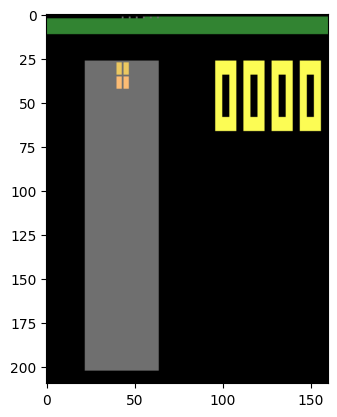

In [6]:
state, reward, done, _, info = env.step(2)
plt.imshow(state)

# Code for Reinforcement Learning Agent

In [7]:
# Define the LSTM-based RL model
class TetrisLSTMAgent():
    def __init__(self, state_size: int, action_size: int):
        self.state_size = state_size
        self.action_size = action_size
        self.memory: Deque[Tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.2
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.train_history = {'loss':[]}

    def _build_model(self) -> tf.keras.Model:
        model = tf.keras.Sequential([
            layers.Input(shape=(None, *self.state_size)),
            layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu')),
            layers.TimeDistributed(layers.MaxPooling2D(2, 2)),
            layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')),
            layers.TimeDistributed(layers.MaxPooling2D(2, 2)),
            layers.TimeDistributed(tf.keras.layers.Flatten()),
            layers.LSTM(64, return_sequences=True),
            layers.LSTM(32),
            layers.Dense(self.action_size),
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self,
                 state: np.ndarray,
                 action: int,
                 reward: float,
                 next_state: np.ndarray,
                 done: bool) -> None:
        '''
        Save the experience to the memory
        '''
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state: np.ndarray):
        '''
        The agent return an action based on the state. The action can be the
        a model prediction or random action base on epsilon (exploration rate)
        '''
        # Choose between random action or model action
        if np.random.rand() <= self.epsilon:
          return random.randrange(self.action_size)
        else:
          state = np.reshape(state, [1, 1, *self.state_size])
          act_values = self.model.predict(state, verbose=0)
          return np.argmax(act_values[0])
        
    def load_model(self, path: str):
        self.model = tf.keras.models.load_model(path)

    def replay(self, batch_size: int):
        '''
        Train the model base using the saved memory on the environment
        '''
        minibatch = random.sample(self.memory, batch_size)
        state_batch = []
        Q_value_batch = []
        # have the model learning from mini batch by replaying it
        for state, action, reward, next_state, done in minibatch:
            # state = np.reshape(state, [1, 1, self.state_size])
            # next_state = np.reshape(next_state, [1, 1, self.state_size])
            state_batch.append(state)
            # set model target as the Q-value from the action
            target = reward
            if not done:
                next_reward = np.amax(
                               self.model.predict(np.expand_dims(next_state, axis=(0, 1)), verbose=0)[0]
                          )
                target = (reward + self.gamma * next_reward)
            # set the action value to target
            target_f = self.model.predict(np.expand_dims(state, axis=(0, 1)), verbose=0)[0]
            target_f[action] = target
            # Add Q_value to training batch
            Q_value_batch.append(target_f)

        # train model
        state_batch = np.array(state_batch)
        Q_value_batch = np.array(Q_value_batch)

        state_batch = np.expand_dims(state_batch, axis=1)
        Q_value_batch = np.expand_dims(Q_value_batch, axis=1)

        hist = self.model.fit(state_batch, Q_value_batch, epochs=1, verbose=1, batch_size=batch_size)
        self.train_history['loss'] += hist.history['loss']
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def plot_model(self, plot_name: str='model.png', save_to: str=''):
      plot_model(self.model, to_file=os.path.join(save_to, plot_name), show_shapes=True, show_layer_names=True)
      model_img = plt.imread(plot_name)
      plt.imshow(model_img)
      plt.axis('off')
      plt.figure(figsize=(10, 10))
      plt.show()

In [8]:
tf.keras.backend.clear_session()
# Initialize the agent

agent = TetrisLSTMAgent(state_size, action_size)

# Load model checkpoint
# model_checkpoint = 'tetris_lstm_model.h5'
# agent.model.load_weights(model_checkpoint)

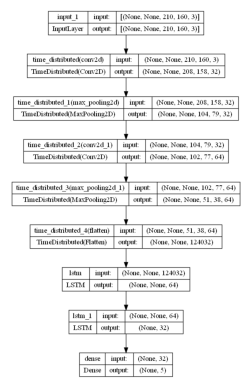

<Figure size 1000x1000 with 0 Axes>

In [9]:
plot_name = 'model_v1.png'
agent.plot_model(plot_name)

# Training the agent

In [35]:
# Training parameters
EPISODES = 50
BATCH_SIZE = 32
EPISODE_MAX_STEPS = 5000

# Main training loop
for e in tqdm(range(EPISODES)):
    env.reset()
    start_state, reward, done, _ , info= env.step(env.action_space.sample())
    state= start_state
    print(f'\n\nthis is episode {e}')
    step_counter = 0
    bonus_reward = 1
    for time in tqdm(range(EPISODE_MAX_STEPS)):  # Limit each episode number of steps
        #get action and next state with model
        action = agent.act(state)
        next_state, reward, done, _ , info= env.step(action)

        agent.remember(state, action, reward+bonus_reward, next_state, done)

        state = next_state
        if done:
            print(f"episode: {e}/{EPISODES}, score: {time}, e: {agent.epsilon}")
            break
    
        # Train the model using agent memory
        if len(agent.memory) > BATCH_SIZE:
            agent.replay(BATCH_SIZE)
            
            bonus_reward += time/100.

            step_counter=0
    
        step_counter += 1
        
    # Save the trained model every episode
    agent.model.save('tetris_lstm_model_checkpoint.h5')
    
    # Log the result after each episode
    with open('train_log.json', 'w') as f:
            json.dump(agent.train_history, f)

  0%|          | 0/50 [00:00<?, ?it/s]



this is episode 0


1/1 [==============================] - 4s 4s/step - loss: 0.2654


1/1 [==============================] - 2s 2s/step - loss: 0.2797


1/1 [==============================] - 2s 2s/step - loss: 0.3009


1/1 [==============================] - 2s 2s/step - loss: 0.3162


1/1 [==============================] - 2s 2s/step - loss: 0.3153


1/1 [==============================] - 2s 2s/step - loss: 0.3674


1/1 [==============================] - 2s 2s/step - loss: 0.4488


1/1 [==============================] - 2s 2s/step - loss: 0.4955


1/1 [==============================] - 2s 2s/step - loss: 0.5402


1/1 [==============================] - 2s 2s/step - loss: 0.5618


1/1 [==============================] - 2s 2s/step - loss: 0.7722


1/1 [==============================] - 2s 2s/step - loss: 0.9462


1/1 [==============================] - 2s 2s/step - loss: 1.1340


1/1 [==============================] - 2s 2s/step - loss: 0.9178


1/1 [==============================] - 2s 2s/step - loss: 1.4747


1/1 [==============================] - 2s 2s/step - loss: 1.5425


1/1 [==============================] - 2s 2s/step - loss: 1.5874


1/1 [==============================] - 2s 2s/step - loss: 2.3377


1/1 [==============================] - 2s 2s/step - loss: 1.8941


1/1 [==============================] - 2s 2s/step - loss: 2.3028


1/1 [==============================] - 2s 2s/step - loss: 2.8319


1/1 [==============================] - 2s 2s/step - loss: 2.4739


  0%|          | 0/50 [02:21<?, ?it/s]


KeyboardInterrupt: 

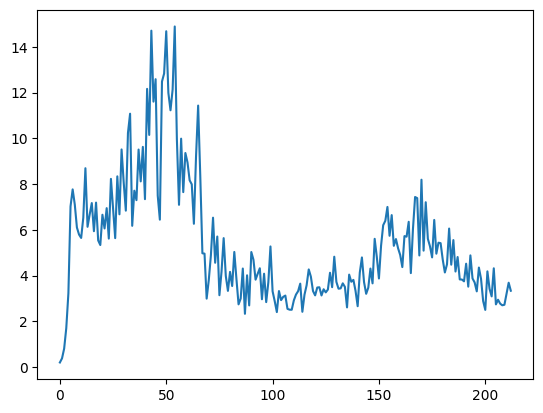

In [18]:
with open('train_log.json', 'r') as f:
    plt.plot(json.load(f)['loss'])

# Testing

### Download model for testing: <a href="https://drive.google.com/drive/folders/1mSn44sBc_bvF4sGPB6Fy4gaaZ9iRv-PM?usp=sharing">link</a>
### Remember to run code for environment first

In [14]:


def display_video(frames):
    # Copied from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                    interval=50, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Create and wrap the environment
env = gym.make("ALE/Tetris-v5", render_mode="rgb_array", frameskip = 4)
frames = []
taken_actions = []
states = []

#change this base on where you save the downloaded model
model_path = "tetris_lstm_model.h5"
agent.model.load_weights(model_path)

# Test the trained model
env.reset()
state = env.step(env.action_space.sample())[0]
state = np.array(state, dtype=float)
state = np.reshape(state, [1, 1, *state_size])
for t in range(5000):

    action = np.argmax(agent.model.predict(state, verbose=0))
    taken_actions.append(action)

    next_state, reward, done, _, info = env.step(action)
    next_state = np.array(next_state)
    states.append(next_state)

    state = np.reshape(next_state, [1, 1, *state_size])

    frames.append(env.render())
    if done:
        break

env.close()
display_video(frames)

c:\Users\Admin\.conda\envs\tfGPU\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
